In [28]:
import pystac
import rioxarray
import rasterio

In [2]:
items = pystac.ItemCollection.from_file("../Data/01_search.json")
# use './data/search.json'
items

In [5]:
assets = items[-1].assets

visual_href = assets["visual"].href    #true color composite

# cog file - Cloud Optimised GeoTiff
visual_href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2A_31UFU_20200321_0_L2A/TCI.tif'

In [6]:
visual = rioxarray.open_rasterio(visual_href, overview_level=2)
print(visual.rio.resolution())    #resolution in m at overview lvl 2

(79.97086671522214, -79.97086671522214)


In [7]:
visual = visual.load()    #untill now the file was only a href to cloud

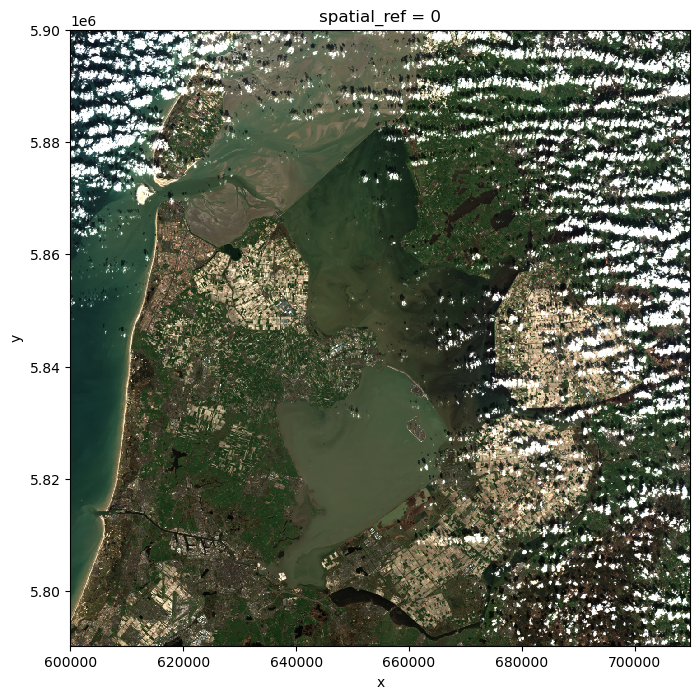

In [18]:
visual.plot.imshow(figsize=(8,8))

## Median Operation rolling with 7x7 window

In [12]:
%%time
median = visual.rolling(x=7, y=7, center=True).median()                ## noise removal | Edge detection


CPU times: total: 14.8 s
Wall time: 16.9 s


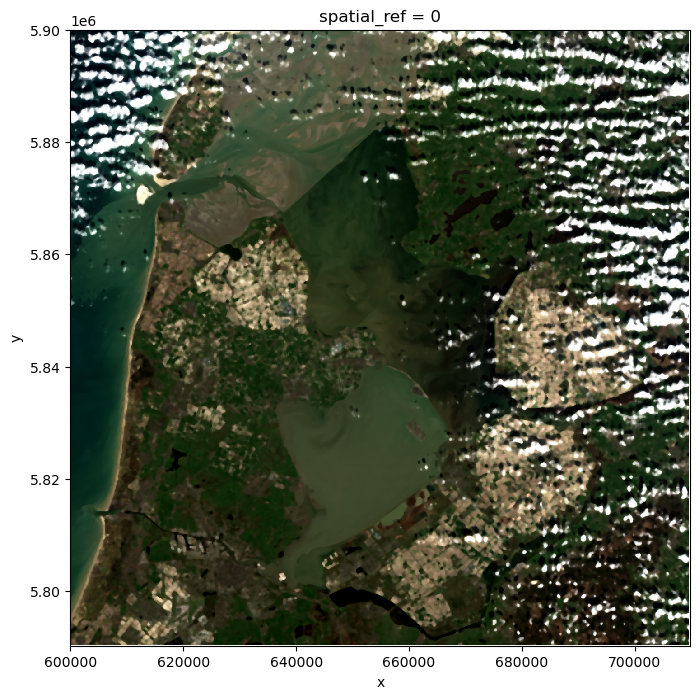

In [17]:
median.plot.imshow(robust=True, figsize = (8,8))

In [19]:
median.rio.to_raster("../Data/07_Visual_Median.tif")

## Chunked Array with Dask

In [23]:
blue_href = assets["blue"].href
blue_band = rioxarray.open_rasterio(blue_href, chunks = (1,4000,4000))

In [25]:
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-bb9b2ce30f7d0b7c18c953045067cb21<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

## Does Chunk Size Matters?

In [31]:
blue_href = assets["blue"].href
blue_band = rioxarray.open_rasterio(blue_href, chunks = (1,4000,4000))

In [33]:
with rasterio.open(blue_href) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")

Chunk size: [(1024, 1024)]


In [41]:
with rasterio.open(blue_href) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")

Chunk size: [(1024, 1024)]


In [44]:
%%time
band = rioxarray.open_rasterio(blue_href, chunks = (1,6144,6144))
band

CPU times: total: 0 ns
Wall time: 16.5 ms


<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-0a8d60903a049268c8bab0df0dba51b3<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 6144, 6144), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [46]:
%%time
band = rioxarray.open_rasterio(blue_href, chunks = "auto")
band

CPU times: total: 0 ns
Wall time: 17.3 ms


<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-e0482a83b59aad29d7a36b8e8d497165<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [61]:
visual_dask = rioxarray.open_rasterio(visual_href, overview_level=2, lock=False, chunks = (3,500,500))

In [62]:
visual_dask

<xarray.DataArray (band: 3, y: 1373, x: 1373)>
dask.array<open_rasterio-c8260d663d293f4b9b57642c4063ebfd<this-array>, shape=(3, 1373, 1373), dtype=uint8, chunksize=(3, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

### Persist - *Do it lazy*
### Compute - *Do it immediately*

In [70]:
pip install graphviz 

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/47.0 kB ? eta -:--:--
     --------------------------------- ---- 41.0/47.0 kB 487.6 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 465.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [71]:
import dask
import graphviz

#### Persist

In [64]:
%%time
visual_dask_persist = visual_dask.persist(scheduler="threads", num_workers=4)                     ## "number of workers" - the core/threads are CPU would use to perform the task 

CPU times: total: 125 ms
Wall time: 3.3 s


In [65]:
%%time
median_dask = visual_dask_persist.rolling(x=7,y=7, center=True).median()

CPU times: total: 0 ns
Wall time: 28.1 ms


#### Compute

In [66]:
%%time
visual_dask_com = visual_dask.compute(scheduler="threads", num_workers=4)                     ## "number of workers" - the core/threads are CPU would use to perform the task 

CPU times: total: 141 ms
Wall time: 3.42 s


In [67]:
%%time
median_dask_com = visual_dask_com.rolling(x=7,y=7, center=True).median()

CPU times: total: 13.5 s
Wall time: 16.2 s


In [73]:
# ## Dask Graph
# dask.visualize(median_dask_com)

### Export

In [74]:
from  threading import Lock

In [76]:
%%time
median_dask.rio.to_raster("../Data/07_visual_median_filter_dask.tif", tilled=True, lock=Lock())          ## "Lock()" will ensure the chunks do not have any overlappings

CPU times: total: 21.3 s
Wall time: 4.61 s
